# Practice Session 09: Forecasting

In this session we will do some time series forecasting on a weather-related time series, which contains temperature, precipitation, and wind speed data for the Barcelona airport. 

The idea of analyzing this time series comes from [this blogpost](https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b) where they use Python's `statsmodel` and other libraries to perform a similar analysis.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

Author: <font color="blue">Judith Camacho</font>

E-mail: <font color="blue">judith.camacho01@estudiant.upf.edu</font>

Date: <font color="blue">30/11/2020</font>

In [211]:
import io
import csv
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math

# 1. Dataset

The dataset we will use is was obtained from [AEMET's Open Data](https://opendata.aemet.es/centrodedescargas/inicio) initiative. We will read it into a dataframe using Pandas' [read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) function.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [269]:
INPUT_FILE = "aemet-barcelona-airport-2016-2020.csv"

In [270]:
weather = pd.read_csv(INPUT_FILE, sep="\t")

weather.set_index('date', inplace=True)
weather.index = pd.to_datetime(weather.index)

weather.head(10)


,temp_min,temp_avg,temp_max,rainfall,windspeed_avg,windspeed_gusts
date,,,,,,
2016-07-01,21.7,24.6,27.5,0.0,3.6,6.7
2016-07-02,20.9,24.2,27.5,0.0,3.9,8.9
2016-07-03,21.1,23.6,26.0,0.0,4.2,9.7
2016-07-04,21.4,24.2,27.1,0.0,2.8,7.8
2016-07-05,22.7,25.9,29.1,0.0,3.3,9.2
2016-07-06,24.2,27.2,30.2,0.0,4.2,10.8
2016-07-07,22.2,25.5,28.8,0.0,5.3,10.3
2016-07-08,24.1,27.6,31.2,0.0,3.9,7.8
2016-07-09,24.2,27.4,30.5,0.0,3.9,8.3


Please note that this dataset contains many NaN values, as in some days observations on precipitation, temperature, or wind speed are missing.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [271]:
display(weather[weather.isna().any(axis=1)])

,temp_min,temp_avg,temp_max,rainfall,windspeed_avg,windspeed_gusts
date,,,,,,
2016-09-25,17.6,21.6,25.7,NaN,6.4,16.9
2016-10-14,13.9,17.6,21.4,NaN,3.3,8.3
2016-10-20,16.2,17.3,18.4,NaN,3.1,10.3
2016-12-17,8.0,11.4,14.8,NaN,8.6,17.5
2017-01-24,NaN,NaN,NaN,0.0,NaN,NaN
2017-01-26,4.1,7.5,10.9,0.0,4.2,NaN
2017-02-14,10.0,13.8,17.6,NaN,2.8,8.9
2017-03-04,6.6,11.3,16.0,NaN,8.3,22.2
2017-03-11,NaN,NaN,NaN,0.0,NaN,NaN


We plot the original series. We notice that there is a substantial variability in minimum, maximum, and average temperature from day to day.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [272]:
# Configure font sizes
plt.rc('font', size=10) 
plt.rc('axes', labelsize=16)
plt.rc('legend', fontsize=16)

In [273]:
# Plot function

def plot(df, column, xlabel='Date', ylabel=''):
    
    # Create a figure
    plt.figure(figsize=(16,5))

    # Plot for dates
    plt.plot_date(df.index, df[column],
                  fmt='.-', color='black')

    # Label axis
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()


def plot_min_avg_max(df, min_column='temp_min', avg_column='temp_avg', max_column='temp_max', xlabel='Date', ylabel='Daily temperature [C]'):

    # Create a figure
    plt.figure(figsize=(16,5))

    # Plot for dates
    plt.plot_date(df.index, df[avg_column],
                  fmt='.-', color='black', label='Average')
    plt.fill_between(df.index, df[min_column], df[max_column],
                     color='lightgray')
    plt.legend()

    # Label axis
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()

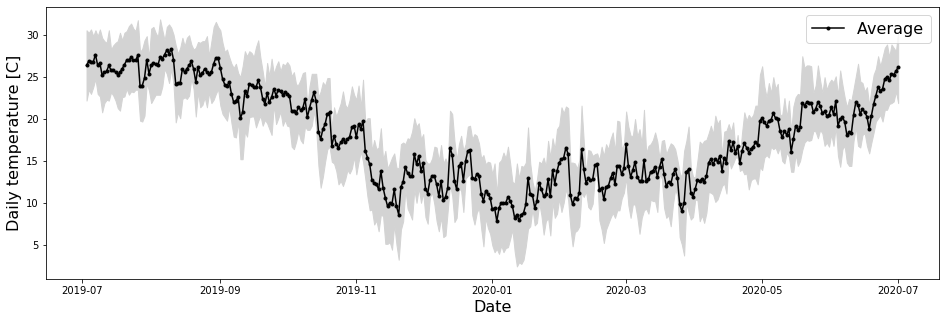

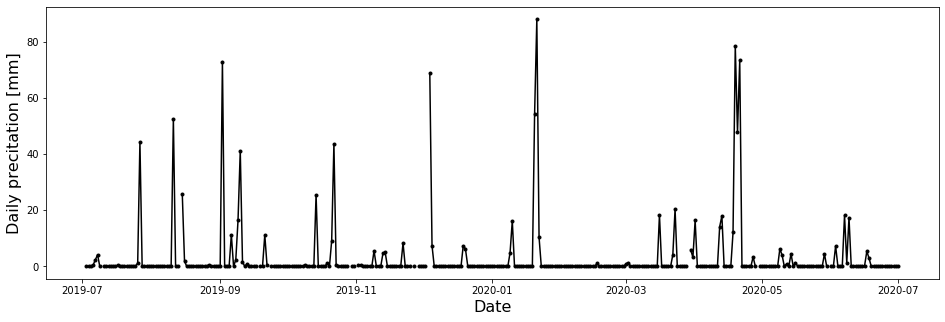

In [274]:
# Retrieve the last year
weather_sample = weather.tail(365)

# Plot temperature
plot_min_avg_max(weather_sample)

# Plot precipitation
plot(weather_sample, "rainfall", ylabel="Daily precitation [mm]")

First plot contains the data of daily temperature and the date. The second plot contains the daily precipitation and the date. For both plots, the x-axis is labeled with month and year. It is not easy to know the season by the plot due to the scale or names of the x-axis.

# 1. Smooth this series

The original series has strong variations from one day to the next one, so we will smooth the series before using it. Here we will use three smoothing methods: moving averages, binning by floating time periods, and binning by calendar time periods.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

## 1.1 Smooth the series using moving averages

We will compute a moving average of the previous `window_size` days (e.g., 7) as a way of smoothing the time series. Create a function `moving_average(df, window_size)` that computes a moving average on all columns of the given dataframe, and returs a new dataframe with the averages. This function can assume that all columns in the input dataframe are numeric.

A possible implementation is to iterate through numbers from `0` to `len(df)` and create a sub-dataframe of up to `window_size` rows with the corresponding rows. If you choose to implement in this way, you can use the following template:

```python
def moving_average(df, window_size):

    smoothed = pd.DataFrame(columns=df.columns)

    for i in range(len(df)):
        # YOUR CODE HERE
        
    smoothed.set_index(df.index, inplace=True)
    
    return smoothed
```

The following might be helpful:

* `len(df)` to obtain the length of a data frame
* `df.iloc[a:b]` to return rows from *a* to *b* on a dataframe.
* `df.mean()` to obtain a series containing the averages of all columns in a dataframe.

If you feel more comfortable working with matrices, you can also use matrices instead of dataframes, and you can also instead of creating a sub-dataframe compute in-place.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [275]:
def moving_average(df, window_size):

    smoothed = pd.DataFrame(columns=df.columns)
    for i in range(len(df)):
        a = max(0,i-window_size)
        b = i+1
        smoothed_aux = df.iloc[a:b]
        smoothed_aux = smoothed_aux.mean()
        smoothed = smoothed.append(smoothed_aux, ignore_index=True)
        
        
    smoothed.set_index(df.index, inplace=True)
        
    return smoothed



Apply this code over the `weather`  correct by verifying the following:

* For day 1, it should be equivalent to the original series
* For day 2, it should be the average of the first two days of the original series
* For day 7, it should be the average of the first 7 days of the original series
* For day 8, it should be the average of the second to the eight day of the original series
* For the last day, it should be the average of the last 7 days in the series

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [276]:
window_size = 7

weather_smoothed = moving_average(weather, window_size)

weather_smoothed.head(10)

,temp_min,temp_avg,temp_max,rainfall,windspeed_avg,windspeed_gusts
date,,,,,,
2016-07-01,21.700000,24.600000,27.500000,0.0,3.600000,6.700000
2016-07-02,21.300000,24.400000,27.500000,0.0,3.750000,7.800000
2016-07-03,21.233333,24.133333,27.000000,0.0,3.900000,8.433333
2016-07-04,21.275000,24.150000,27.025000,0.0,3.625000,8.275000
2016-07-05,21.560000,24.500000,27.440000,0.0,3.560000,8.460000
2016-07-06,22.000000,24.950000,27.900000,0.0,3.666667,8.850000
2016-07-07,22.028571,25.028571,28.028571,0.0,3.900000,9.057143
2016-07-08,22.287500,25.350000,28.425000,0.0,3.900000,8.900000
2016-07-09,22.600000,25.700000,28.800000,0.0,3.937500,9.100000


Now we plot the resulting series, observing that it is, well, smoother.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

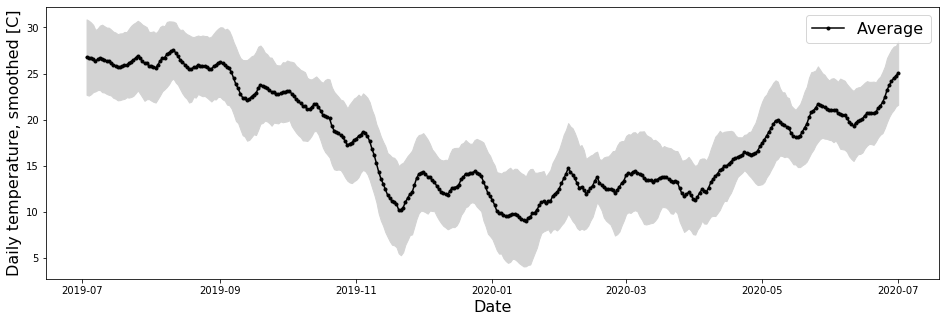

In [277]:
# Sample last 365 days
weather_smoothed_sample = weather_smoothed.tail(365)

plot_min_avg_max(weather_smoothed_sample, ylabel='Daily temperature, smoothed [C]')

The main dificulties I found were related with the iloc. I had to try several values of a and b before getting the aproppiate ones.

## 1.2. Smooth the series by binning per floating weeks

Note: Pandas have powerful methods for [re-sampling a series](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html) that we will **not** use. Instead, we want to understand every step of the resampling process.

First, we build a list of `weeks` that starts with the first day of the studied period and then adds one week until passing over the last day of the studied period.

You can use the following template:

```python
def list_of_floating_week_starts(first, last):
    weeks = []
    
    # YOUR CODE HERE
    
    return(weeks)
```

In the list that should be generated:

* The first element should be *first*
* The next elements should be *first + 1 week*, *first + 2 weeks*, ...
* The last element should be in the week after *last*

To add one week to date *D*, use `D + datetime.timedelta(weeks=1)`.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [278]:
def list_of_floating_week_starts(first, last):
    weeks = []
    
    num_weeks = math.ceil((last - first).days / 7)+1

    for x in range(num_weeks):
        weeks.append(first)
        first += datetime.timedelta(weeks=1)
    
    
    return(weeks)

There should be **210** week starts in your dataset, if you have just 209 you need to add one more in the end, it will make your life easier. Note these weeks *float* because they do not start in the calendar start of the week such as Monday.
 
 <font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [279]:
first_day = np.min(weather.index)
last_day = np.max(weather.index)
weeks = list_of_floating_week_starts(first_day, last_day)

print("There are %d week starts" % len(weeks))
print("First week starts %s, last week starts %s" % (weeks[0].strftime("%Y-%m-%d"), weeks[-1].strftime("%Y-%m-%d")))
print(first_day, last_day)

There are 210 week starts
First week starts 2016-07-01, last week starts 2020-07-03
2016-07-01 00:00:00 2020-07-01 00:00:00


Now, we find the week that corresponds to every element in the time_series.

 <font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [280]:
# Create a map from dates to week starts
date_to_week_start= {}
week_num = 0
for date, row in weather.iterrows():
    while not (date >= weeks[week_num] and date < weeks[week_num+1]):
        week_num += 1
    date_to_week_start[date] = weeks[week_num]
    
# Create a new dataframe with an extra column
weather_with_week_start = weather
weather_with_week_start['week_start'] = [date_to_week_start[date] for date in weather.index]
weather_with_week_start

,temp_min,temp_avg,temp_max,rainfall,windspeed_avg,windspeed_gusts,week_start
date,,,,,,,
2016-07-01,21.7,24.6,27.5,0.0,3.6,6.7,2016-07-01
2016-07-02,20.9,24.2,27.5,0.0,3.9,8.9,2016-07-01
2016-07-03,21.1,23.6,26.0,0.0,4.2,9.7,2016-07-01
2016-07-04,21.4,24.2,27.1,0.0,2.8,7.8,2016-07-01
2016-07-05,22.7,25.9,29.1,0.0,3.3,9.2,2016-07-01
...,...,...,...,...,...,...,...
2020-06-27,21.8,24.6,27.4,0.0,3.6,8.3,2020-06-26
2020-06-28,21.9,25.4,28.9,0.0,4.2,8.9,2020-06-26
2020-06-29,22.1,25.3,28.5,0.0,3.3,7.2,2020-06-26


Third, we create a new dataframe with the average temperature (min, avg, max), and the total rainfall per floating week.

You can solve this by creating a matrix and then converting into a dataframe.

You can also use Panda's [groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) function together with the [aggregate](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.aggregate.html) function. There are many different ways of passing parameters to `aggregate`, check the one in which you pass a dictionary in which the keys are column names and the values are functions (in this case, you should use `np.mean` for `temp_*` and `np.sum` for `rainfall`).

 <font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [281]:
weather_per_floating_week = weather_with_week_start.groupby("week_start").agg({"temp_avg": "mean",
                                                                             "temp_min": "mean",
                                                                             "temp_avg": "mean",
                                                                             "temp_max": "mean",
                                                                              "rainfall": "sum"})
weather_per_floating_week.head()

,temp_avg,temp_min,temp_max,rainfall
week_start,,,,
2016-07-01,25.028571,22.028571,28.028571,0.0
2016-07-08,25.757143,22.571429,28.971429,5.0
2016-07-15,23.928571,20.414286,27.457143,1.5
2016-07-22,25.342857,21.457143,29.228571,7.7
2016-07-29,26.800000,23.728571,29.857143,0.0


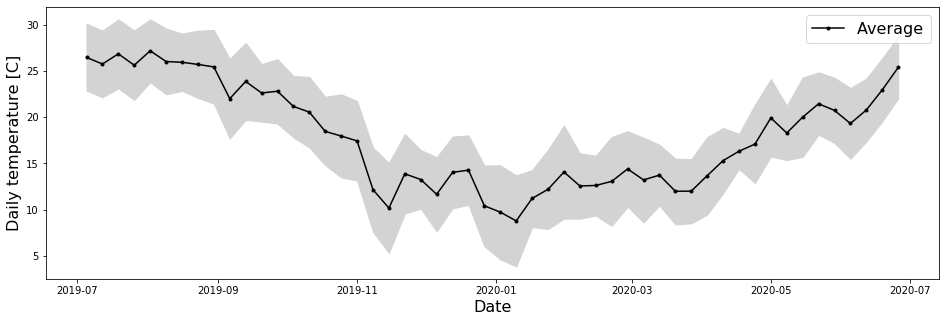

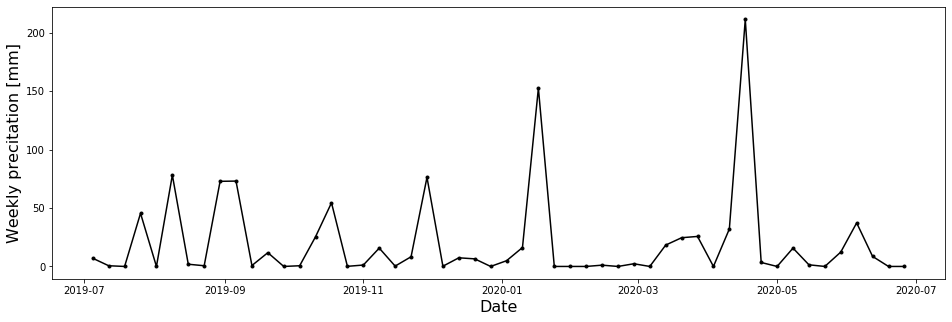

In [282]:
# Retrieve the last year
weather_sample = weather_per_floating_week.tail(52)

# Plot temperature
plot_min_avg_max(weather_sample, )

# Plot precipitation
plot(weather_sample, "rainfall", ylabel="Weekly precitation [mm]")

We have just calculated the mean for each temperature variable over a week.
So now we see the mean values for each week of all the temperature variables. Like this we have plotted, not only the average but also the range (gray zone) into which the values have moved for that week.

For the second plot, we can see the total mm of precipitation for every week.

We can see that the plots is are more zoomed in, so we can see less peaks (still we see a lot). It is smoother.

## 1.3. Smooth the series by binning per month

Now we repeat the process for months instead of weeks. Now, however, we want to align with the **beginning of a calendar month**.

Create the function `list_of_month_starts(first, last)`. It should return an array containing entries of the form *Year-Month-01*, that is the first of every month. It should start with the first of the month of the first observation, and end with the first of the month following the last observation.

* Given date D, to obtain the first of the month use `D1 = D.replace(day=1)`
* Given date D, to obtain the same date in the next month:
   * If *D.month < 12*, use `D2 = D.replace(month=D.month+1)`
   * If *D.month == 12*, use `D2 = D.replace(year=D.year+1, month=1)`

 <font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [283]:
def list_of_month_starts(first, last):
    months = []
    
    first = first.replace(day=1)
    last = last.replace(month=last.month+1)
    num_months = math.ceil((last - first).days / 30)
    print(num_months)
    for x in range(num_months):
        if first.month < 12:
            months.append(first)
            first = first.replace(month=first.month+1)
        elif first.month == 12:
            months.append(first)
            first = first.replace(year=first.year+1, month=1)
    
    
    return(months)

You should obtain **50** month starts. The first month should start on *2016-07-01* and the last month start on *2020-08-01*. Note that the last month starts after the end of the series. 

 <font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [284]:
first_day = np.min(weather.index)
last_day = np.max(weather.index)
months = list_of_month_starts(first_day, last_day)


print("There are %d month starts" % len(months))
print("First month starts %s, last month starts %s" % (months[0].strftime("%Y-%m-%d"), months[-1].strftime("%Y-%m-%d")))


50
There are 50 month starts
First month starts 2016-07-01, last month starts 2020-08-01


As before, we create a dataframe with the month start.

 <font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [285]:
# Create a map from dates to week starts
date_to_month_start= {}
month_num = 0
for date, row in weather.iterrows():
    while not (date >= months[month_num] and date < months[month_num+1]):
        month_num += 1
    date_to_month_start[date] = months[month_num]
    
# Create a new dataframe with an extra column
weather_with_month_start = weather
weather_with_month_start['month_start'] = [date_to_month_start[date] for date in weather.index]
weather_with_month_start

,temp_min,temp_avg,temp_max,rainfall,windspeed_avg,windspeed_gusts,week_start,month_start
date,,,,,,,,
2016-07-01,21.7,24.6,27.5,0.0,3.6,6.7,2016-07-01,2016-07-01
2016-07-02,20.9,24.2,27.5,0.0,3.9,8.9,2016-07-01,2016-07-01
2016-07-03,21.1,23.6,26.0,0.0,4.2,9.7,2016-07-01,2016-07-01
2016-07-04,21.4,24.2,27.1,0.0,2.8,7.8,2016-07-01,2016-07-01
2016-07-05,22.7,25.9,29.1,0.0,3.3,9.2,2016-07-01,2016-07-01
...,...,...,...,...,...,...,...,...
2020-06-27,21.8,24.6,27.4,0.0,3.6,8.3,2020-06-26,2020-06-01
2020-06-28,21.9,25.4,28.9,0.0,4.2,8.9,2020-06-26,2020-06-01
2020-06-29,22.1,25.3,28.5,0.0,3.3,7.2,2020-06-26,2020-06-01


As before, aggregate per month to create a dataframe with averages of `temp_min`, `temp_avg`, and `temp_max` per month, and sum of `rainfall`.

 <font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [286]:
weather_per_month = weather_with_month_start.groupby("week_start").agg({"temp_avg": "mean",
                                                                             "temp_min": "mean",
                                                                             "temp_avg": "mean",
                                                                             "temp_max": "mean",
                                                                              "rainfall": "sum"})
weather_per_month.head()

,temp_avg,temp_min,temp_max,rainfall
week_start,,,,
2016-07-01,25.028571,22.028571,28.028571,0.0
2016-07-08,25.757143,22.571429,28.971429,5.0
2016-07-15,23.928571,20.414286,27.457143,1.5
2016-07-22,25.342857,21.457143,29.228571,7.7
2016-07-29,26.800000,23.728571,29.857143,0.0


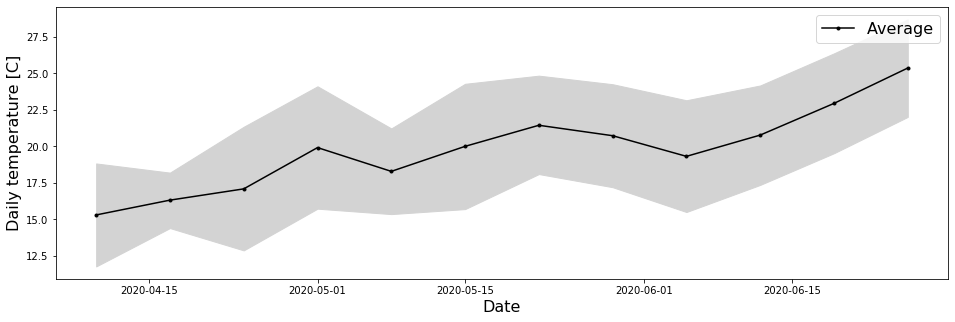

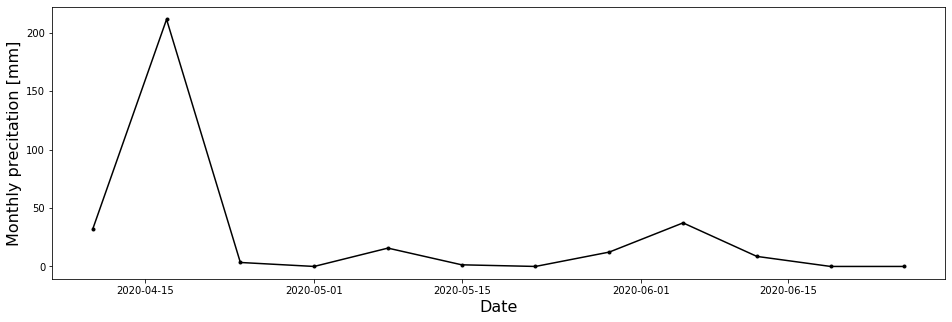

In [287]:
# Retrieve the last year
weather_sample = weather_per_month.tail(12)

# Plot temperature
plot_min_avg_max(weather_sample)

# Plot precipitation
plot(weather_sample, "rainfall", ylabel="Monthly precitation [mm]")

We have for every month, the average of the variables temp_, and the sum of the precipiation values.

We can see that the plot is now more zoomed in, so we can see less peaks. It is smoother.

# 2. Perform forecasting

We will next perform a simple auto-regressive forecasting.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

## 2.1. Compute auto-correlation plots

We will start by computing auto-correlation plots, which show to what extent a series is correlated with itself if we consider a certain `lag`, or time difference.

The function `lagged_series` returns the original series, and a second series computed by looking at *lag* periods in the past. It also takes care of the edges of both series, so they will be of the same length.

You can use the following template:

```python
def lagged_series(series, lag):
    original = []
    lagged = []
    for i in range(len(series)):
        j = i - lag
        # YOUR CODE HERE
        # You have to append series[i] to original and series[j] to lagged
        # but only if j is in [0, len(series)-1]
    return original, lagged
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [288]:
def lagged_series(series, lag):
    original = []
    lagged = []
    for i in range(len(series)):
        j = i - lag
        if j in range(0, len(series)-1):
            original.append(series[i])
            lagged.append(series[j])
 
    return original, lagged

Test your code. For the series `[10,20,30,40,50,60]` and a lag of *2* you should obtain the two series `[30, 40, 50, 60]` and `[10, 20, 30, 40]`.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [289]:
lagged_series([10,20,30,40,50,60], 2)

([30, 40, 50, 60], [10, 20, 30, 40])

The function `autocorrelation`, which you can leave as-is, simply computes Pearson's correlation between a series and the series lagged *lag* periods.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [290]:
# Computes the correlation between two vectors, considering
# only the positions in which both vectors are not NaN
def correlation_without_nan(x,y):
    positions_to_remove = ~np.logical_or(np.isnan(x), np.isnan(y))

    x_without_nan = np.compress(positions_to_remove, x)
    y_without_nan = np.compress(positions_to_remove, y)
    return stats.pearsonr(x_without_nan,y_without_nan)[0]  

# Compute autocorrelation
def autocorrelation(series, lag):
    x,y = lagged_series(series, lag)
            
    return correlation_without_nan(x,y)

Now we will create auto-correlation plots. Create a function `compute_autocorrelations(series, max_periods)` that returns all the auto-correlations of a series from period `0` to `max_periods-1`.

Use this function to create an array `auto_correlation_temp` containing the correlations of `weather['temp_avg']`, and an array `auto_correlation_rainfall` containing the correlations of `weather['rainfall']`.

Use `max_periods=365`.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [291]:
def compute_autocorrelations(series, max_periods):
    correlations = []
    for lag in range(max_periods):
        corr = autocorrelation(series, lag)
        correlations.append(corr)
    return correlations

In [292]:
max_periods=365
auto_correlations_temp = compute_autocorrelations(weather['temp_avg'], max_periods)
auto_correlations_rainfall = compute_autocorrelations(weather['rainfall'], max_periods)

Now we plot these.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [293]:
def plot_auto_correlations(correlations, xlabel="Lag (days)", ylabel="Autocorrelation"):
    # Figure
    plt.figure(figsize=(15,4))

    # Plot correlation
    plt.plot(range(len(correlations)), correlations, '-o')

    # Add xticks every 10 periods
    plt.xticks(np.arange(0, len(correlations), 10), rotation=90)

    # Add a horizontal line at zero
    plt.hlines(0, xmin=0, xmax=len(correlations))

    # Add labels
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()

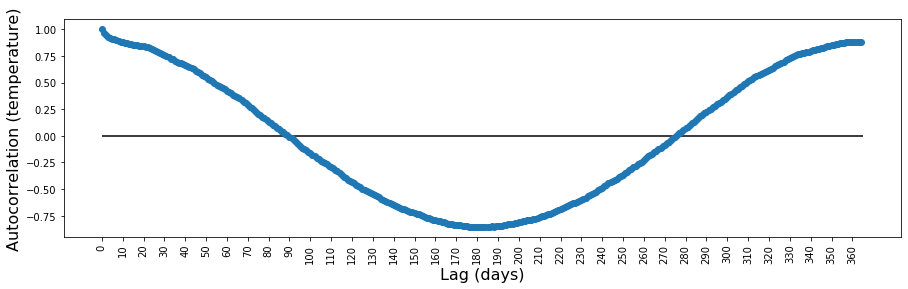

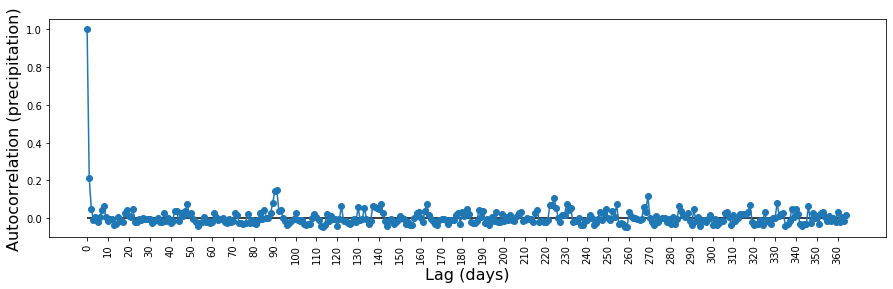

In [294]:
# Plot temperature auto-correlation
plot_auto_correlations(auto_correlations_temp, ylabel="Autocorrelation (temperature)")

# Plot precipitation auto-correlation
plot_auto_correlations(auto_correlations_rainfall, ylabel="Autocorrelation (precipitation)")

The first plot shows that from one year to another and in short term, there is a correlation. It makes sense that there is correlation between the temperatures along the different days (due to the seasons). Correlation of approx one from days 0 to 10 and from 350 to 360 (that represents the annual and short term). 

For the second plot, we can see that the correlation does not follow any patter, so we might assume that it rains "randomly".


It might be the case that aggregating by week we obtain a stronger auto-correlation of the precipitation time series. Let us try it.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

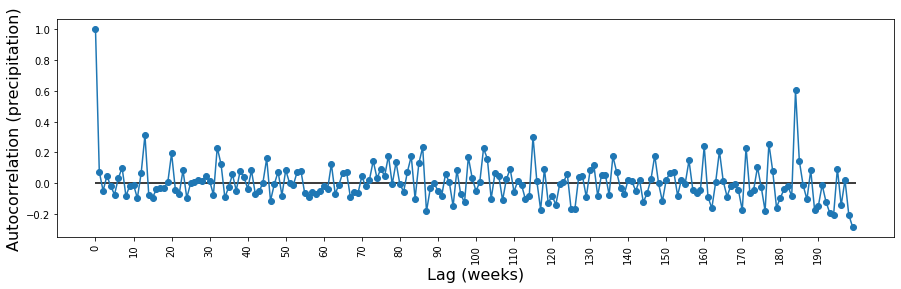

In [295]:
auto_correlations_rainfall_week = compute_autocorrelations(weather_per_floating_week['rainfall'], 200)

plot_auto_correlations(auto_correlations_rainfall_week, xlabel='Lag (weeks)', ylabel="Autocorrelation (precipitation)")

In this case, the data is just a little bit more stable, maybe because bad weather usually lasts for 1 day or more. Still, with this plot we are not able to predict anything, and it is still very spurious.

## 2.2. Prepare a system of equations to learn an auto-regressive model

We will now learn an auto-regressive model, which computes the current value from a series of values in the past, at different *lags*.

**Example:** In the explanation we will assume there are two lags (2, 3) only. This means that the value will be predicted on the basis of the value observed 2 and 3 periods ago. The equation is then *y[i] = y[i-2] x alpha + y[i-3] x beta*, with *alpha* and *beta* being two unknown coefficients that we must determine. Suppose the series is: [11, 19, 32, 38, 51, 58, 68, 81]. From this series, we create the following system of equations.

* 19 x alpha + 11 x beta = 38
* 32 x alpha + 19 x beta = 51
* ...
* 58 x alpha + 51 x beta = 81

Unless the data is generated by a very specific process, we will seldom satisfy this system of equations, but we can approximately satisfy it. We will use SciKit's [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) to obtain *alpha* and *beta*. To use this function, we need to prepare to matrices: *X*, which will contain the numbers in the left side of the equations, and *y* which will be a vector containing the numbers in the right side of the equations.

Create a function `prepare_matrices`. You can use the following template:

```python
def prepare_matrices(series, lags):
    y = []
    X = []
    
    for lag in lags:
        assert(lag > 0)
        assert(lag < len(series))
    
    for i in range(np.max(lags), len(series)):
        # YOUR CODE HERE
        
        X.append(row)
        y.append(series[i])
        
    return X, y
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [296]:
def prepare_matrices(series, lags):
    y = []
    X = []

    for lag in lags:
        assert(lag > 0)
        assert(lag < len(series))

    for i in range(np.max(lags), len(series)):
        row = [series[i-lag] for lag in lags]
        if np.nan not in row and series[i] is not np.nan:
            X.append(row)
            y.append(series[i])

    return X, y

Test your code. Given the series `[11, 19, 32, 38, 51, 58, 69, 81]` and lags `[2, 3]`, you should obtain:

```
X=[[19, 11], [32, 19], [38, 32], [51, 38], [58, 51]]
y=[38, 51, 58, 69, 81]
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [297]:
X, y = prepare_matrices([11, 19, 32, 38, 51, 58, 69, 81], [2, 3])
print("X=%s" % X)
print("y=%s" % y)

X=[[19, 11], [32, 19], [38, 32], [51, 38], [58, 51]]
y=[38, 51, 58, 69, 81]


Notice that your code must handle well missing values. If any of the equations contains a NaN in the left or right side, you should discard it. In other words, X cannot contains vectors that have NaN values, and y cannot contain NaN values.

For instance, given the series `[11, 19, 32, np.nan, 51, 58, 69, 81]` and lags `[2, 3]`, you should obtain:

```
X=[[32, 19], [58, 51]]
y=[51, 81]
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [298]:
X, y = prepare_matrices([11, 19, 32, np.nan, 51, 58, 69, 81], [2, 3])
print("X=%s" % X)
print("y=%s" % y)

X=[[32, 19], [58, 51]]
y=[51, 81]


## 2.3. Perform forecasts

We first define a couple of functions to perform and plot the forecast, which you can leave as-is.

Function `perform_forecast` simply uses your `prepare_matrices` function to prepare a system of equations, and then calls [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) in SciKit-Learn to try to find a solution.

We measured the error as RMSE (Root Mean Squared Error) divided by the difference between the maximum and minimum value we want to predict. See [NRMSD](https://en.wikipedia.org/wiki/Root-mean-square_deviation#Normalized_root-mean-square_deviation).

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [299]:
def perform_forecast(series, lags):

    # Prepare matrices for linear regression
    X, y = prepare_matrices(series, lags)

    # Perform forecast
    linear_regressor = LinearRegression()
    linear_regressor.fit(X,y)
    y_pred = linear_regressor.predict(X)

    # Compute forecasting error
    # Root mean squared error, normalized
    rmse = math.sqrt(mean_squared_error(y, y_pred))/(np.max(y)-np.min(y))
    
    # Return: observed, predicted, error
    return (y, y_pred, rmse)

def plot_forecast(y, y_pred, xlabel="Period", ylabel="", nrmsd=-1):

    plt.figure(figsize=(15,4))
    
    plt.plot(y, '.-', color='black', label='Observed')
    plt.plot(y_pred, '--', linewidth=3, color='red', label=('Model (NRMSD=%.2f)' % nrmsd if nrmsd > 0 else 'Model'))
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.legend()
    plt.show()

First, predict the monthly temperature. Set `lags_monthly_temperature = [...]` to be an array of up to 4 lags. Use the auto-correlation plots you draw before as a guideline.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [300]:
lags_monthly_temperature = [1, 4, 8, 10]

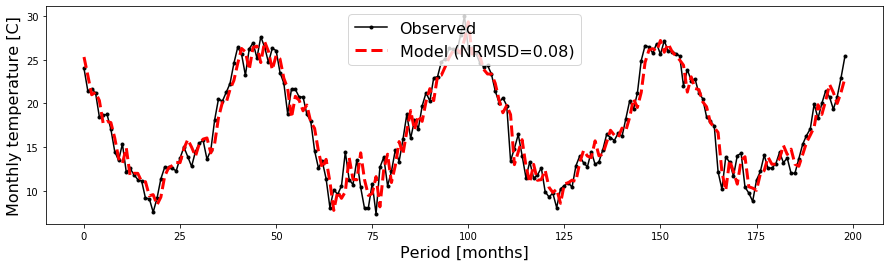

In [301]:
(y, y_pred, nrmsd) = perform_forecast(weather_per_month['temp_avg'], lags_monthly_temperature)
plot_forecast(y, y_pred, xlabel="Period [months]", ylabel="Monthly temperature [C]", nrmsd=nrmsd)

For the purposes of this practice, we ask you to optimize the lags to find the smaller error. That is not what we would do in a real application, in which we would seek optimal values for the lags on a separate training set, and validate it on a testing set.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

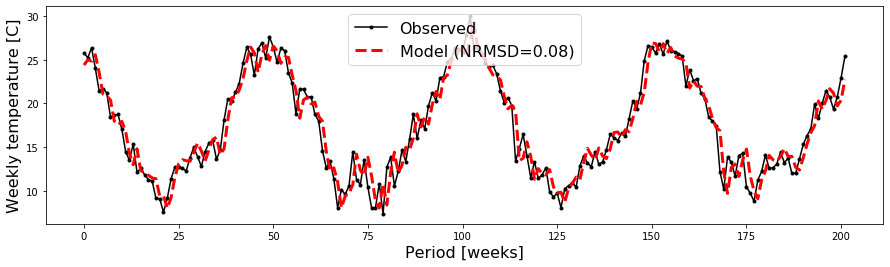

In [302]:
lags_weekly_temperature = [1, 2, 5, 7]
(y, y_pred, nrmsd) = perform_forecast(weather_per_floating_week['temp_avg'], lags_weekly_temperature)
plot_forecast(y, y_pred, xlabel="Period [weeks]", ylabel="Weekly temperature [C]", nrmsd=nrmsd)

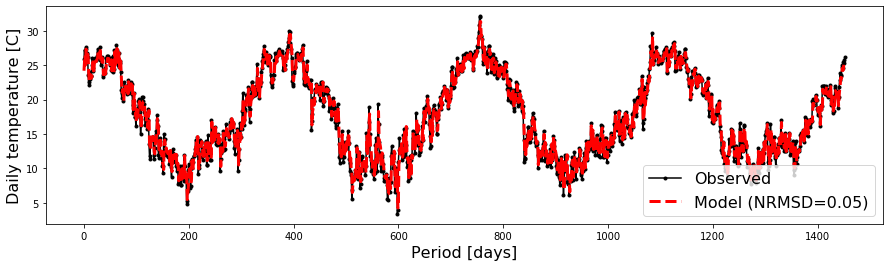

In [303]:
weather_per_day = weather.groupby("date").agg({"temp_avg": "mean",
                                                "temp_min": "mean",
                                                "temp_avg": "mean",
                                                "temp_max": "mean",
                                                 "rainfall": "sum"}).dropna()

lags_daily_temperature = [1, 2, 3, 4]
(y, y_pred, nrmsd) = perform_forecast(weather_per_day['temp_avg'], lags_daily_temperature)
plot_forecast(y, y_pred, xlabel="Period [days]", ylabel="Daily temperature [C]", nrmsd=nrmsd)


When predicting the temperature, our predictions fit quite well when doing both daily and weekly. The difference, is that, when daily predicting, just with 4 lags we get almost a perfect fit with many more points then using lag for monthly prediction.

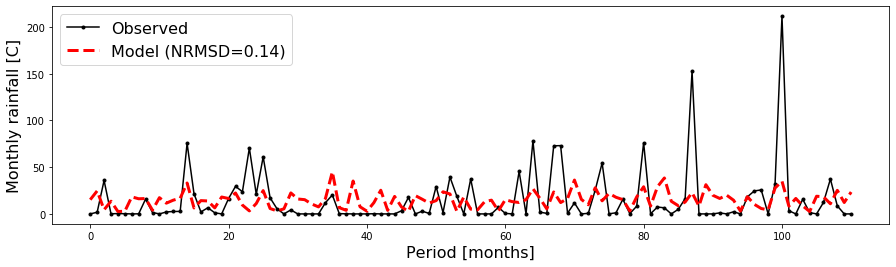

In [304]:
lags_monthly_rainfall = [50,66, 85, 98]


(y, y_pred, nrmsd) = perform_forecast(weather_per_month['rainfall'], lags_monthly_rainfall)
plot_forecast(y, y_pred, xlabel="Period [months]", ylabel="Monthly rainfall [C]", nrmsd=nrmsd)


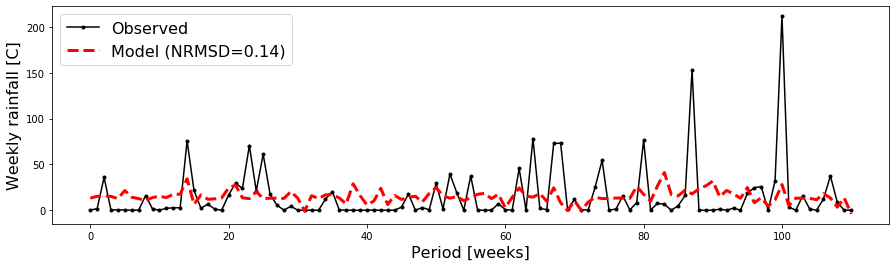

In [305]:
# lags_weekly_temperature = [1,4, 6, 8]
lags_weekly_rainfall = [10,46, 65, 98]


(y, y_pred, nrmsd) = perform_forecast(weather_per_floating_week['rainfall'], lags_weekly_rainfall)
plot_forecast(y, y_pred, xlabel="Period [weeks]", ylabel="Weekly rainfall [C]", nrmsd=nrmsd)

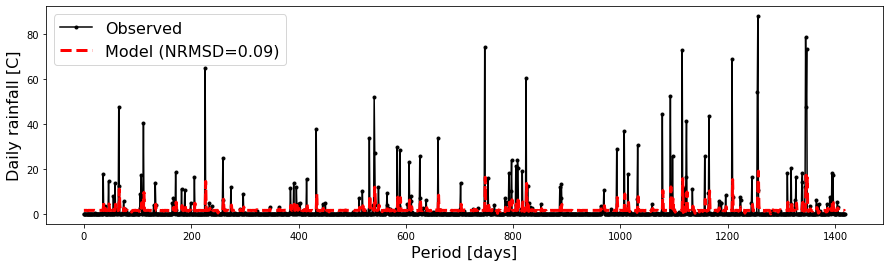

In [306]:
lags_daily_rainfall = [1,12, 24, 38]


(y, y_pred, nrmsd) = perform_forecast(weather_per_day['rainfall'], lags_daily_rainfall)
plot_forecast(y, y_pred, xlabel="Period [days]", ylabel="Daily rainfall [C]", nrmsd=nrmsd)

It is very difficult to find a good model for the rain since there is almost no correlation and the data is very spurious. 
Even though I have tried many values for the lags, these are the best approximations I have found.
If we had more data, it will be easier to find a better model. Also, maybe to predict the rain, we should use another kind of model.

# DELIVER (individually)

Remember to read the section on "delivering your code" in the [course evaluation guidelines](https://github.com/chatox/data-mining-course/blob/master/upf/upf-evaluation.md).

Deliver a zip file containing:

* This notebook

## Extra points available

For more learning and extra points, create a model for temperature that uses cross-correlations. This means, you can use the variables *temp_min*, *temp_avg*, *temp_max*, *rainfall*, *windspeed_avg*, and *windspeed_gusts* up to the previous day to predict *temp_avg* on the current day. You only need to be careful not to include any `lag=0` measure, otherwise you would not be predicting the future. Include plots and a brief commentary indicating whether you obtained any improvements.

**Note:** if you go for the extra points, add ``<font size="+2" color="blue">Additional results: cross correlations</font>`` at the top of your notebook. 

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>